In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [2]:
!nvidia-smi

Tue Apr 20 01:12:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.87       Driver Version: 456.87       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   68C    P8     8W /  N/A |    626MiB /  6144MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
from   torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [6]:
from RandSamp import getSamples, getSamplOrig
from moabb.datasets import BNCI2014001
from moabb.paradigms import (LeftRightImagery, MotorImagery,
                         FilterBankMotorImagery)
# Extraer los datos
dataset = BNCI2014001()
paradigm = MotorImagery(n_classes=4,
                    fmin=8,
                    fmax=35,
                    tmin=-2,
                    tmax=5)

Choosing from all possible events


In [7]:
#X = np.load("/content/drive/My Drive/data/Graz/X_EEG.npy")
#y = np.load("/content/drive/My Drive/data/Graz/y_EEG.npy")
#metadata = pd.read_csv("/content/drive/My Drive/data/Graz/metadata_EEG.csv")
X, y, metadata = paradigm.get_data(dataset=dataset, subjects=[1,2,3,4,5,6,7,8,9])
# Load paradigm 
#paradigm = MotorImagery(n_classes=4, fmin=8, fmax=35)

#print(paradigm.__doc__)


#print(paradigm.__doc__)


In [8]:
X2 = X#np.array([[x[:, :1000]] for x in X])
np.shape(X2)

(5184, 22, 1751)

In [9]:
X_train = X2[(metadata["session"]=="session_T")]
y_train = y[(metadata["session"]=="session_T")]

X_test = X2[(metadata["session"]=="session_E")]
y_test = y[(metadata["session"]=="session_E")]

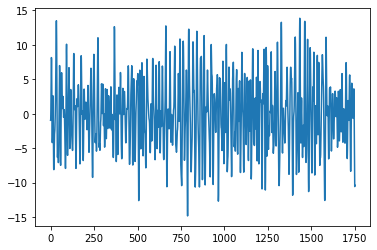

In [10]:
plt.plot(X_train[0, 0])

In [11]:
mxx = np.max(X_train) / 4
X_train = (X_train / mxx)
X_test = (X_test / mxx)

#X_train = torch.from_numpy(X_train).float().cuda()
#X_test = torch.from_numpy(X_test).float().cuda()

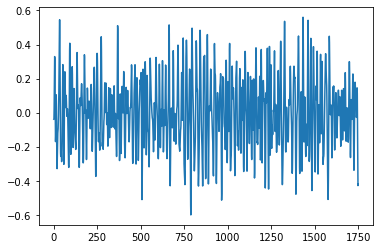

In [12]:
plt.plot(X_train[0, 0,])

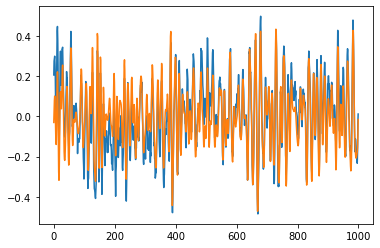

In [13]:
samples, originals = getSamplOrig(X_train, samples=10, ruido="eog", ns=7000)
plt.plot(samples[0, 0])
plt.plot(originals[0, 0])

In [14]:
#trainloader = DataLoader(X_train, batch_size=128, shuffle=True)
#testloader = DataLoader(X_test, batch_size=128, shuffle=True)
#originals.shape

samples.shape

(160, 22, 1000)

In [41]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        #### Encoder
        self.conv1 = nn.Sequential(
            nn.Conv1d(22, 32, 3), 
            nn.ELU(),
            nn.BatchNorm1d(32),
            nn.MaxPool1d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, 3),  
            nn.ELU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, 3),
            nn.ELU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(2),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, 3),
            nn.ELU(),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(2),  
        )

        
        
        ### Decoder 
        self.convt1 = nn.Sequential(
            nn.ConvTranspose1d(256, 128, 5, 2), 
            nn.ELU(),
            nn.BatchNorm1d(128),
        )
        
        self.convt2 = nn.Sequential(
            nn.ConvTranspose1d(128, 64, 5, 2), 
            nn.ELU(),
            nn.BatchNorm1d(64),
        )
        
        self.convt3 = nn.Sequential(
            nn.ConvTranspose1d(64, 32, 5, 2), 
            nn.ELU(),
            nn.BatchNorm1d(32),
        )
        
        self.convt4 = nn.Sequential(
            nn.ConvTranspose1d(32, 22, 3, 2), 
            #nn.Tanh()
        )
        
        self.encoder = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
        )
        
        self.decoder = nn.Sequential(
            self.convt1,
            self.convt2,
            self.convt3,
            self.convt4,
        )

    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    

    

In [42]:
torch.cuda.empty_cache()
learning_rate = 0.001
autoencoder = Autoencoder().cuda()

criterion = nn.MSELoss()
#optimizer = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), lr=learning_rate)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [43]:
with torch.no_grad():
    output = autoencoder(torch.from_numpy(samples[:, :, :250]).float().cuda())
    #encoded = autoencoder.encoder(torch.from_numpy(samples[:, :, :1001]).float().cuda())
    
print(output.shape)

TypeError: expected np.ndarray (got Tensor)

In [53]:
Cost = []
#encoder.train()
#decoder.train()

autoencoder.train()
for epoch in range(200):
    runnning_loss = 0
    samples, originals = getSamplOrig(X_train, samples=10, ruido="eog", ns=10000)
    samples = torch.from_numpy(samples).float().cuda()
    originals = torch.from_numpy(originals).float().cuda()

    # ===================forward=====================
    #encoded = encoder(data)
    output = autoencoder(samples)[:, :22, 1:1001]
    loss = criterion(output, originals[:, :22, :1000])
    Cost.append(loss.item())
    runnning_loss += loss.item()
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 25 == 24:
        print("Epoca: ", epoch, " loss: ", runnning_loss)
        running_loss = 0


Epoca:  24  loss:  0.017500320449471474
Epoca:  49  loss:  0.012580456212162971
Epoca:  74  loss:  0.01904166489839554
Epoca:  99  loss:  0.010553978383541107
Epoca:  124  loss:  0.009240570478141308
Epoca:  149  loss:  0.010873842984437943
Epoca:  174  loss:  0.00812466535717249
Epoca:  199  loss:  0.008863053284585476


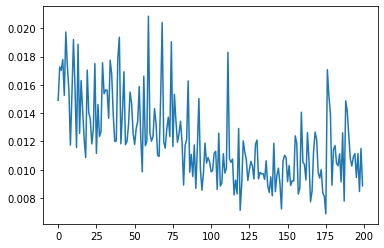

In [54]:
#with torch.no_grad():
#    out = model.encoder(data)
plt.plot(Cost)

In [55]:
#print(encoded.shape)
print(output.shape)

torch.Size([160, 22, 1000])


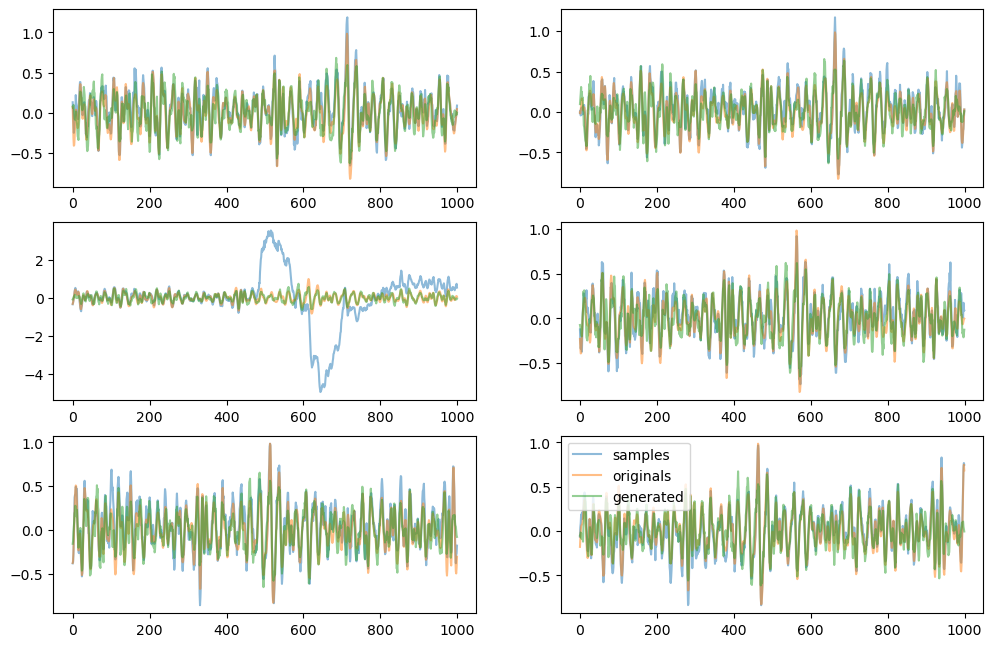

In [56]:
#encoder.eval()
#decoder.eval()
autoencoder.eval()
with torch.no_grad():
    output = autoencoder(samples)[:, :22, 1:1001]

plt.figure(figsize=(12, 8), dpi=100)
for i in range(6):
    plt.subplot(3, 2, i+1)
    plt.plot(samples[i,0].cpu().numpy(),
             label="samples",
            alpha=0.5)
    plt.plot(originals[i,0].cpu().numpy(),
             label="originals",
            alpha=0.5)
    plt.plot(output[i,0].cpu().numpy(),
             label="generated",
            alpha=0.5)

plt.legend()
plt.show()

In [57]:
from matplotlib.colors import ListedColormap
# Define colores
esmeralda = "#2ecc71"
belize = "#2980b9"
pome = "#c0392b"
ameth = "#9b59b6"
sun = "#f1c40f"
pumpkin = "#d35400"

palette = ListedColormap([esmeralda, belize, pome, ameth])
# Configuración de matplotlib
#plt.rcParams["font.family"] = "Palatino Linotype"
plt.rcParams["font.size"] = 10
plt.rcParams["font.weight"] = "regular"
plt.rcParams['font.family'] = 'serif'

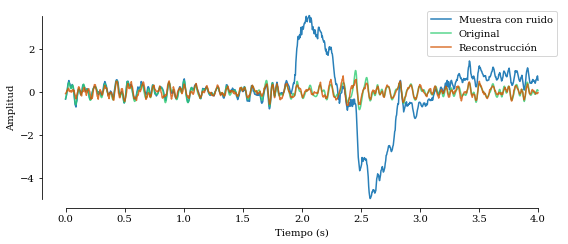

In [71]:
tiempo = np.linspace(0, 4, len(output[1,0].cpu()))
fig, ax = plt.subplots(figsize=(8,3.5))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(0, 4)
ax.spines['left'].set_bounds(min(samples[2,0].cpu().numpy()), max(samples[2,0].cpu().numpy()))

ax.plot(tiempo, samples[2,0].cpu().numpy(),
 color=belize,
 label="Muestra con ruido")
ax.plot(tiempo, originals[2,0].cpu().numpy(),
 color=esmeralda,
 alpha=0.8,
 label="Original")
ax.plot(tiempo, output[2,0].cpu().numpy(),
color=pumpkin,
alpha=0.8,
 label="Reconstrucción")


plt.legend()
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.tight_layout()
plt.savefig("figures/reconDA2.pdf")

In [31]:
with torch.no_grad():
    output = autoencoder(torch.from_numpy(samples[:, :, :250]).float().cuda())
    #encoded = autoencoder.encoder(samples[:, :, :1001].float().cuda())
    
print(encoded.shape)



TypeError: expected np.ndarray (got Tensor)

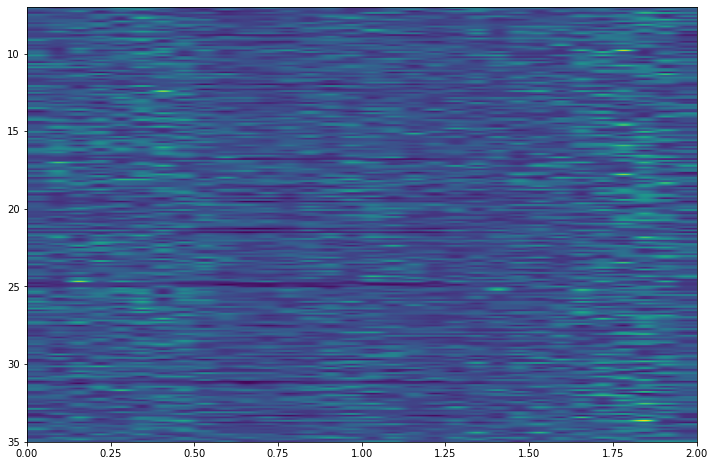

In [121]:
plt.figure(figsize=(12, 8))
plt.imshow(encoded.detach().cpu().numpy()[2], extent=[0, 2, 35, 7], aspect="auto")

In [23]:
signaa = encoded.detach().cpu().numpy()[42]

plt.figure(dpi=300)
for i in range(10):
    plt.plot(signaa[i], color="steelblue", alpha=0.8)

NameError: name 'encoded' is not defined

In [24]:
# Cargar datos originales
X2 = np.load("X_EEG.npy")
y2 = np.load("y_EEG.npy")
metadata = pd.read_csv("metadata_EEG.csv")

X_train2 = X2[(metadata["session"]=="session_T")]
y_train2 = y2[(metadata["session"]=="session_T")]

X_test2 = X2[(metadata["session"]=="session_E")]
y_test2 = y2[(metadata["session"]=="session_E")]

mxx = np.max(X_train2) / 4
X_train2 = (X_train2 / mxx)
X_test2 = (X_test2 / mxx)

X_train_gpu = torch.from_numpy(X_train2).float().cuda()
X_test_gpu = torch.from_numpy(X_test2).float().cuda()

dataTrain = DataLoader(X_train_gpu, batch_size=128, shuffle=True)
dataTest = DataLoader(X_test_gpu, batch_size=128, shuffle=True)

In [25]:
## Error en el set de entrenamiento
with torch.no_grad():
    running_error = 0
    for data in dataTrain:
        out = autoencoder(data)[:, :22, :1001]
        running_error += (data*mxx-out*mxx).pow(2).mean().item()

RuntimeError: The size of tensor a (1001) must match the size of tensor b (995) at non-singleton dimension 2

In [ ]:
np.sqrt(running_error)

In [ ]:
with torch.no_grad():
    running_error = 0
    for data in dataTest:
        out = autoencoder(data)[:, :22, :1001]
        running_error += (data*mxx-out*mxx).pow(2).mean().item()

In [ ]:
np.sqrt(running_error)

In [75]:
autoencoder

Autoencoder(
  (conv1): Sequential(
    (0): Conv1d(22, 32, kernel_size=(16,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(12,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(12,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv1d(128, 256, kernel_size=(10,), stride=(1,))
    (1): ELU(alpha=1.0)
    (2): BatchNorm1d(256, eps=1e-05, mom

In [76]:
torch.save(autoencoder.state_dict(), "autoencoder1D_noise2.pt")